# Forecasting geomagnetic storms using support vector machine for classification
***


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             roc_curve, precision_recall_curve, average_precision_score, 
                             fbeta_score, recall_score, make_scorer)

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [2]:
# Load raw dataframe
df = pd.read_csv("../data/data_storms.csv")

print(df.info())
print(df.shape)
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244535 entries, 0 to 244534
Data columns (total 19 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   datetime     244535 non-null  object 
 1   ABS_B        244535 non-null  float64
 2   F            244535 non-null  float64
 3   BX_GSE       244535 non-null  float64
 4   BY_GSE       244535 non-null  float64
 5   BZ_GSE       244535 non-null  float64
 6   SIGMA-ABS_B  244535 non-null  float64
 7   SIGMA-B      244535 non-null  float64
 8   SIGMA-Bx     244535 non-null  float64
 9   SIGMA-By     244535 non-null  float64
 10  SIGMA-Bz     244535 non-null  float64
 11  T            244535 non-null  float64
 12  N            244535 non-null  float64
 13  V            244535 non-null  float64
 14  Ratio        244535 non-null  float64
 15  Pressure     244535 non-null  float64
 16  R            244535 non-null  int64  
 17  DST          244535 non-null  float64
 18  storm_now    244535 non-

# Changing the dataframe to fit SVM
***

In [3]:
# Ensure the 'datetime' column is in datetime format
df['datetime'] = pd.to_datetime(df['datetime'])

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244535 entries, 0 to 244534
Data columns (total 19 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   datetime     244535 non-null  datetime64[ns]
 1   ABS_B        244535 non-null  float64       
 2   F            244535 non-null  float64       
 3   BX_GSE       244535 non-null  float64       
 4   BY_GSE       244535 non-null  float64       
 5   BZ_GSE       244535 non-null  float64       
 6   SIGMA-ABS_B  244535 non-null  float64       
 7   SIGMA-B      244535 non-null  float64       
 8   SIGMA-Bx     244535 non-null  float64       
 9   SIGMA-By     244535 non-null  float64       
 10  SIGMA-Bz     244535 non-null  float64       
 11  T            244535 non-null  float64       
 12  N            244535 non-null  float64       
 13  V            244535 non-null  float64       
 14  Ratio        244535 non-null  float64       
 15  Pressure     244535 non-null  floa

In [4]:
# Analyze storm distribution over time

# Number of storm-hours per year
df_storms = df.groupby(df['datetime'].dt.year)['storm_now'].agg(['sum'])
print(df_storms)

          sum
datetime     
1995      371
1996       31
1997      284
1998      555
1999      424
2000      554
2001      677
2002      904
2003      335
2004      354
2005      533
2006       93
2007       20
2008       12
2009       17
2010       84
2011      201
2012      425
2013      224
2014      163
2015      659
2016      219
2017      213
2018       80
2019       24
2020       21
2021       51
2022      159
2023      386
2024      572


In [5]:
# Number of hours with storms (count should be 8760 [24*365] or 8784 for leap years)
# values below 8784 indicate some missing hours
yearly_storms = df.groupby(df['datetime'].dt.year)['storm_now'].agg(['sum', 'count'])
print("\nHours with storm distribution by year:")
print(yearly_storms)


Hours with storm distribution by year:
          sum  count
datetime            
1995      371   8628
1996       31   8578
1997      284   8121
1998      555   8328
1999      424   6840
2000      554   7034
2001      677   7466
2002      904   7613
2003      335   6439
2004      354   6948
2005      533   8508
2006       93   7723
2007       20   8230
2008       12   8649
2009       17   8550
2010       84   7966
2011      201   8313
2012      425   8651
2013      224   8412
2014      163   6897
2015      659   8670
2016      219   8741
2017      213   8712
2018       80   8751
2019       24   8643
2020       21   8722
2021       51   8549
2022      159   8716
2023      386   8614
2024      572   8523


In [6]:
# function to created the lagged features
def create_lagged_features(df, n_hours=3):
    """
    Create features using the last n_hours of data to predict the next hour's storm.
    """
    df = df.copy()
    df['datetime'] = pd.to_datetime(df['datetime'])
    df = df.sort_values('datetime').reset_index(drop=True)
    
    # Features to use (exclude datetime and target)
    feature_cols = [col for col in df.columns if col not in ['datetime', 'storm_now']]
    
    # Create lagged features for each of the past n_hours
    lagged_df = pd.DataFrame(index=df.index) # important to keep the index for alignment
    
    for i in range(1, n_hours + 1):
        for col in feature_cols:
            lagged_df[f'{col}_lag{i}'] = df[col].shift(i)
    
    # Target: next hour's storm (shift storm_now by -1)
    lagged_df['target'] = df['storm_now'].shift(-1)
    lagged_df['datetime'] = df['datetime']
    
    # Drop rows with NaN (first n_hours rows and last row)
    lagged_df = lagged_df.dropna()
    
    return lagged_df

In [7]:
# Create the lagged features for the past 3 hours
lagged_data = create_lagged_features(df, n_hours=3)

print(lagged_data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 244531 entries, 3 to 244533
Data columns (total 53 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   ABS_B_lag1        244531 non-null  float64       
 1   F_lag1            244531 non-null  float64       
 2   BX_GSE_lag1       244531 non-null  float64       
 3   BY_GSE_lag1       244531 non-null  float64       
 4   BZ_GSE_lag1       244531 non-null  float64       
 5   SIGMA-ABS_B_lag1  244531 non-null  float64       
 6   SIGMA-B_lag1      244531 non-null  float64       
 7   SIGMA-Bx_lag1     244531 non-null  float64       
 8   SIGMA-By_lag1     244531 non-null  float64       
 9   SIGMA-Bz_lag1     244531 non-null  float64       
 10  T_lag1            244531 non-null  float64       
 11  N_lag1            244531 non-null  float64       
 12  V_lag1            244531 non-null  float64       
 13  Ratio_lag1        244531 non-null  float64       
 14  Pressure_

In [8]:
# The dataset is too big to run the hyperparameter opitmization in my PC, so I am going to use a sample for this part
lagged_data_short = lagged_data.sample(frac=0.05)
print(lagged_data_short.info())

<class 'pandas.core.frame.DataFrame'>
Index: 12227 entries, 111096 to 109364
Data columns (total 53 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   ABS_B_lag1        12227 non-null  float64       
 1   F_lag1            12227 non-null  float64       
 2   BX_GSE_lag1       12227 non-null  float64       
 3   BY_GSE_lag1       12227 non-null  float64       
 4   BZ_GSE_lag1       12227 non-null  float64       
 5   SIGMA-ABS_B_lag1  12227 non-null  float64       
 6   SIGMA-B_lag1      12227 non-null  float64       
 7   SIGMA-Bx_lag1     12227 non-null  float64       
 8   SIGMA-By_lag1     12227 non-null  float64       
 9   SIGMA-Bz_lag1     12227 non-null  float64       
 10  T_lag1            12227 non-null  float64       
 11  N_lag1            12227 non-null  float64       
 12  V_lag1            12227 non-null  float64       
 13  Ratio_lag1        12227 non-null  float64       
 14  Pressure_lag1     122

In [9]:
# chronological split is important for time series
lagged_data_short = lagged_data_short.sort_values('datetime').reset_index(drop=True)
assert lagged_data_short['datetime'].is_monotonic_increasing

print(lagged_data_short.head())

   ABS_B_lag1  F_lag1  BX_GSE_lag1  BY_GSE_lag1  BZ_GSE_lag1  \
0         4.8     4.8         -4.3          2.1          0.3   
1         9.2     6.7          2.4          5.8          2.4   
2         6.0     4.5          3.4         -2.9          0.1   
3         6.3     5.7          5.4          0.6          1.8   
4         5.6     4.3          3.5         -2.3         -0.9   

   SIGMA-ABS_B_lag1  SIGMA-B_lag1  SIGMA-Bx_lag1  SIGMA-By_lag1  \
0               0.1           0.3            0.2            0.2   
1               1.4           6.2            3.2            3.6   
2               0.5           3.8            1.0            3.0   
3               0.2           2.4            0.6            1.9   
4               0.3           3.4            1.0            1.8   

   SIGMA-Bz_lag1  ...  SIGMA-Bz_lag3    T_lag3  N_lag3  V_lag3  Ratio_lag3  \
0            0.2  ...            1.8   20703.0    19.3   320.0      0.0120   
1            3.9  ...            2.0  238691.0     8.8  

# Fitting the model
***

In [10]:
# let's check all columns to dorp some on the next step
print(lagged_data_short.columns)

Index(['ABS_B_lag1', 'F_lag1', 'BX_GSE_lag1', 'BY_GSE_lag1', 'BZ_GSE_lag1',
       'SIGMA-ABS_B_lag1', 'SIGMA-B_lag1', 'SIGMA-Bx_lag1', 'SIGMA-By_lag1',
       'SIGMA-Bz_lag1', 'T_lag1', 'N_lag1', 'V_lag1', 'Ratio_lag1',
       'Pressure_lag1', 'R_lag1', 'DST_lag1', 'ABS_B_lag2', 'F_lag2',
       'BX_GSE_lag2', 'BY_GSE_lag2', 'BZ_GSE_lag2', 'SIGMA-ABS_B_lag2',
       'SIGMA-B_lag2', 'SIGMA-Bx_lag2', 'SIGMA-By_lag2', 'SIGMA-Bz_lag2',
       'T_lag2', 'N_lag2', 'V_lag2', 'Ratio_lag2', 'Pressure_lag2', 'R_lag2',
       'DST_lag2', 'ABS_B_lag3', 'F_lag3', 'BX_GSE_lag3', 'BY_GSE_lag3',
       'BZ_GSE_lag3', 'SIGMA-ABS_B_lag3', 'SIGMA-B_lag3', 'SIGMA-Bx_lag3',
       'SIGMA-By_lag3', 'SIGMA-Bz_lag3', 'T_lag3', 'N_lag3', 'V_lag3',
       'Ratio_lag3', 'Pressure_lag3', 'R_lag3', 'DST_lag3', 'target',
       'datetime'],
      dtype='object')


In [11]:
# Separate features and target
# I started using the DST feature, and it is very useful, but it is not always available in real-time forecasts
# datetime may not be a problem or leak information, but I am excluding it just to be sure
#feature_cols = [col for col in lagged_data.columns if col not in ['datetime', 'storm_now']]
feature_cols = [col for col in lagged_data_short.columns if col not in ['datetime', 'target', 'DST_lag1', 'DST_lag2', 'DST_lag3']] 
X = lagged_data_short[feature_cols]
y = lagged_data_short['target']

print(X.columns)

Index(['ABS_B_lag1', 'F_lag1', 'BX_GSE_lag1', 'BY_GSE_lag1', 'BZ_GSE_lag1',
       'SIGMA-ABS_B_lag1', 'SIGMA-B_lag1', 'SIGMA-Bx_lag1', 'SIGMA-By_lag1',
       'SIGMA-Bz_lag1', 'T_lag1', 'N_lag1', 'V_lag1', 'Ratio_lag1',
       'Pressure_lag1', 'R_lag1', 'ABS_B_lag2', 'F_lag2', 'BX_GSE_lag2',
       'BY_GSE_lag2', 'BZ_GSE_lag2', 'SIGMA-ABS_B_lag2', 'SIGMA-B_lag2',
       'SIGMA-Bx_lag2', 'SIGMA-By_lag2', 'SIGMA-Bz_lag2', 'T_lag2', 'N_lag2',
       'V_lag2', 'Ratio_lag2', 'Pressure_lag2', 'R_lag2', 'ABS_B_lag3',
       'F_lag3', 'BX_GSE_lag3', 'BY_GSE_lag3', 'BZ_GSE_lag3',
       'SIGMA-ABS_B_lag3', 'SIGMA-B_lag3', 'SIGMA-Bx_lag3', 'SIGMA-By_lag3',
       'SIGMA-Bz_lag3', 'T_lag3', 'N_lag3', 'V_lag3', 'Ratio_lag3',
       'Pressure_lag3', 'R_lag3'],
      dtype='object')


In [12]:
# Split into train and test sets

# Use last 20% as test set
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print(f"\nTraining samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"\nClass distribution in training set:")
print(y_train.value_counts())
print(f"Percentage of positive cases in train: {y_train.mean()*100:.2f}%")
print(f"\nClass distribution in test set:")
print(y_test.value_counts())
print(f"Percentage of positive cases in test: {y_test.mean()*100:.2f}%")


Training samples: 9781
Test samples: 2446

Class distribution in training set:
target
0.0    9435
1.0     346
Name: count, dtype: int64
Percentage of positive cases in train: 3.54%

Class distribution in test set:
target
0.0    2376
1.0      70
Name: count, dtype: int64
Percentage of positive cases in test: 2.86%


In [13]:
# scoring metric
scoring = make_scorer(fbeta_score, beta=2)

In [14]:
# Use TimeSeriesSplit for cross-validation in time series data
tscv = TimeSeriesSplit(n_splits=5)

In [15]:
# Define the pipeline
# GridSearchCV with balanced and umbalanced data
pipe = Pipeline([
    ("scaler", StandardScaler()),
    #('smote', SMOTE(random_state=42)),
    ("svm", SVC(class_weight='balanced', probability=True, random_state=42))
])

# Define parameter grid
param_grid = [
    {'svm__kernel': ['linear'], 'svm__C': [0.1, 1, 10, 100]},
    {'svm__kernel': ['rbf'], 'svm__C': [0.1, 1, 10, 100], 'svm__gamma': ['scale', 0.01, 0.001]},
    {'svm__kernel': ['poly'], 'svm__C': [0.1, 1, 10, 100], 'svm__gamma': ['scale', 0.01, 0.001]}
]

In [16]:
# you can just load the model if already trained and not run the grid search and best model again
try:
    best_svm = joblib.load("../data/storms_best_SVM.pkl")
except:
    print("No saved model found, proceeding to train a new model.")

In [17]:
# Search for the best hyperparameters
grid_search = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=tscv,
    scoring=scoring,
    n_jobs=-1,
    verbose=1
)

print("\nStarting grid search for SVM (this may take a while)...")
grid_search.fit(X_train, y_train)

print("Best hyperparameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)


Starting grid search for SVM (this may take a while)...
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Best hyperparameters: {'svm__C': 1, 'svm__gamma': 0.001, 'svm__kernel': 'rbf'}
Best cross-validation score: 0.5259053121358986


In [18]:
# now, I am going to use the full dataset to train the final model using the best hyperparameters found

lagged_data = lagged_data.sort_values('datetime').reset_index(drop=True)
assert lagged_data['datetime'].is_monotonic_increasing

# I tested using and not using the DST feature, and the results were better with it
X_full = lagged_data.drop(['datetime', 'target', 'DST_lag1', 'DST_lag2', 'DST_lag3'], axis=1)
#X_full = lagged_data.drop(['datetime', 'target'], axis=1)
y_full = lagged_data['target']

split_idx = int(len(X) * 0.8)
X_train_full, X_test_full = X_full.iloc[:split_idx], X_full.iloc[split_idx:]
y_train_full, y_test_full = y_full.iloc[:split_idx], y_full.iloc[split_idx:]

scaler_full = StandardScaler()
X_train_full_scaled = scaler_full.fit_transform(X_train_full)
X_test_full_scaled = scaler_full.transform(X_test_full)

#smote_full = SMOTE(random_state=42)
#X_train_full_balanced, y_train_full_balanced = smote_full.fit_resample(X_train_full_scaled, y_train_full)

In [19]:
# Train final model with best hyperparameters on balanced data
best_svm = grid_search.best_estimator_  # pipeline with scaler + best SVM
best_svm.fit(X_train_full_scaled, y_train_full)
print(best_svm.named_steps['svm'])

# Save the best model
joblib.dump(best_svm, "../data/storms_best_SVM.pkl")
print("Best model saved to ../data/storms_best_SVM.pkl")

SVC(C=1, class_weight='balanced', gamma=0.001, probability=True,
    random_state=42)
Best model saved to ../data/storms_best_SVM.pkl


In [20]:
# Make predictions
y_pred = best_svm.predict(X_test_full_scaled)
y_pred_proba = best_svm.predict_proba(X_test_full_scaled)[:, 1]

# Results
***

In [21]:
# Evaluation
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test_full, y_pred)
print(cm)

print("\nClassification Report:")
print(classification_report(y_test_full, y_pred))

if len(np.unique(y_test)) > 1:
    f2_score = fbeta_score(y_test_full, y_pred, beta=2)
    f1_score = fbeta_score(y_test_full, y_pred, beta=1)
    recall = recall_score(y_test_full, y_pred)
    avg_precision = average_precision_score(y_test_full, y_pred_proba)
    roc_auc = roc_auc_score(y_test_full, y_pred_proba)
    
    print(f"Average F2 Score: {f2_score:.4f}")
    print(f"Average F1 Score: {f1_score:.4f}")
    print(f"Average Recall Score: {recall:.4f}")
    print(f"Average Precision Score: {avg_precision:.4f}")
    print(f"ROC-AUC Score: {roc_auc:.4f}")


Confusion Matrix:
[[182637  43839]
 [  1529   6745]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.81      0.89    226476
         1.0       0.13      0.82      0.23      8274

    accuracy                           0.81    234750
   macro avg       0.56      0.81      0.56    234750
weighted avg       0.96      0.81      0.87    234750

Average F2 Score: 0.4030
Average F1 Score: 0.2292
Average Recall Score: 0.8152
Average Precision Score: 0.3725
ROC-AUC Score: 0.8916


In [22]:
# Analyze different classification thresholds
print("\nThreshold Analysis:")

thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
for thresh in thresholds:
    y_pred_thresh = (y_pred_proba >= thresh).astype(int)
    cm_thresh = confusion_matrix(y_test_full, y_pred_thresh)
    tn, fp, fn, tp = cm_thresh.ravel() if cm_thresh.size == 4 else (cm_thresh[0,0], 0, 0, 0)
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    print(f"\nThreshold = {thresh}")
    print(f"  TP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}")
    print(f"  Precision: {precision:.3f}, Recall: {recall:.3f}")


Threshold Analysis:

Threshold = 0.3
  TP: 3046, FP: 4234, TN: 222242, FN: 5228
  Precision: 0.418, Recall: 0.368

Threshold = 0.4
  TP: 2438, FP: 2454, TN: 224022, FN: 5836
  Precision: 0.498, Recall: 0.295

Threshold = 0.5
  TP: 1967, FP: 1531, TN: 224945, FN: 6307
  Precision: 0.562, Recall: 0.238

Threshold = 0.6
  TP: 1536, FP: 917, TN: 225559, FN: 6738
  Precision: 0.626, Recall: 0.186

Threshold = 0.7
  TP: 1185, FP: 527, TN: 225949, FN: 7089
  Precision: 0.692, Recall: 0.143



Visualization saved as 'geomag_storm_SVM_results.png'


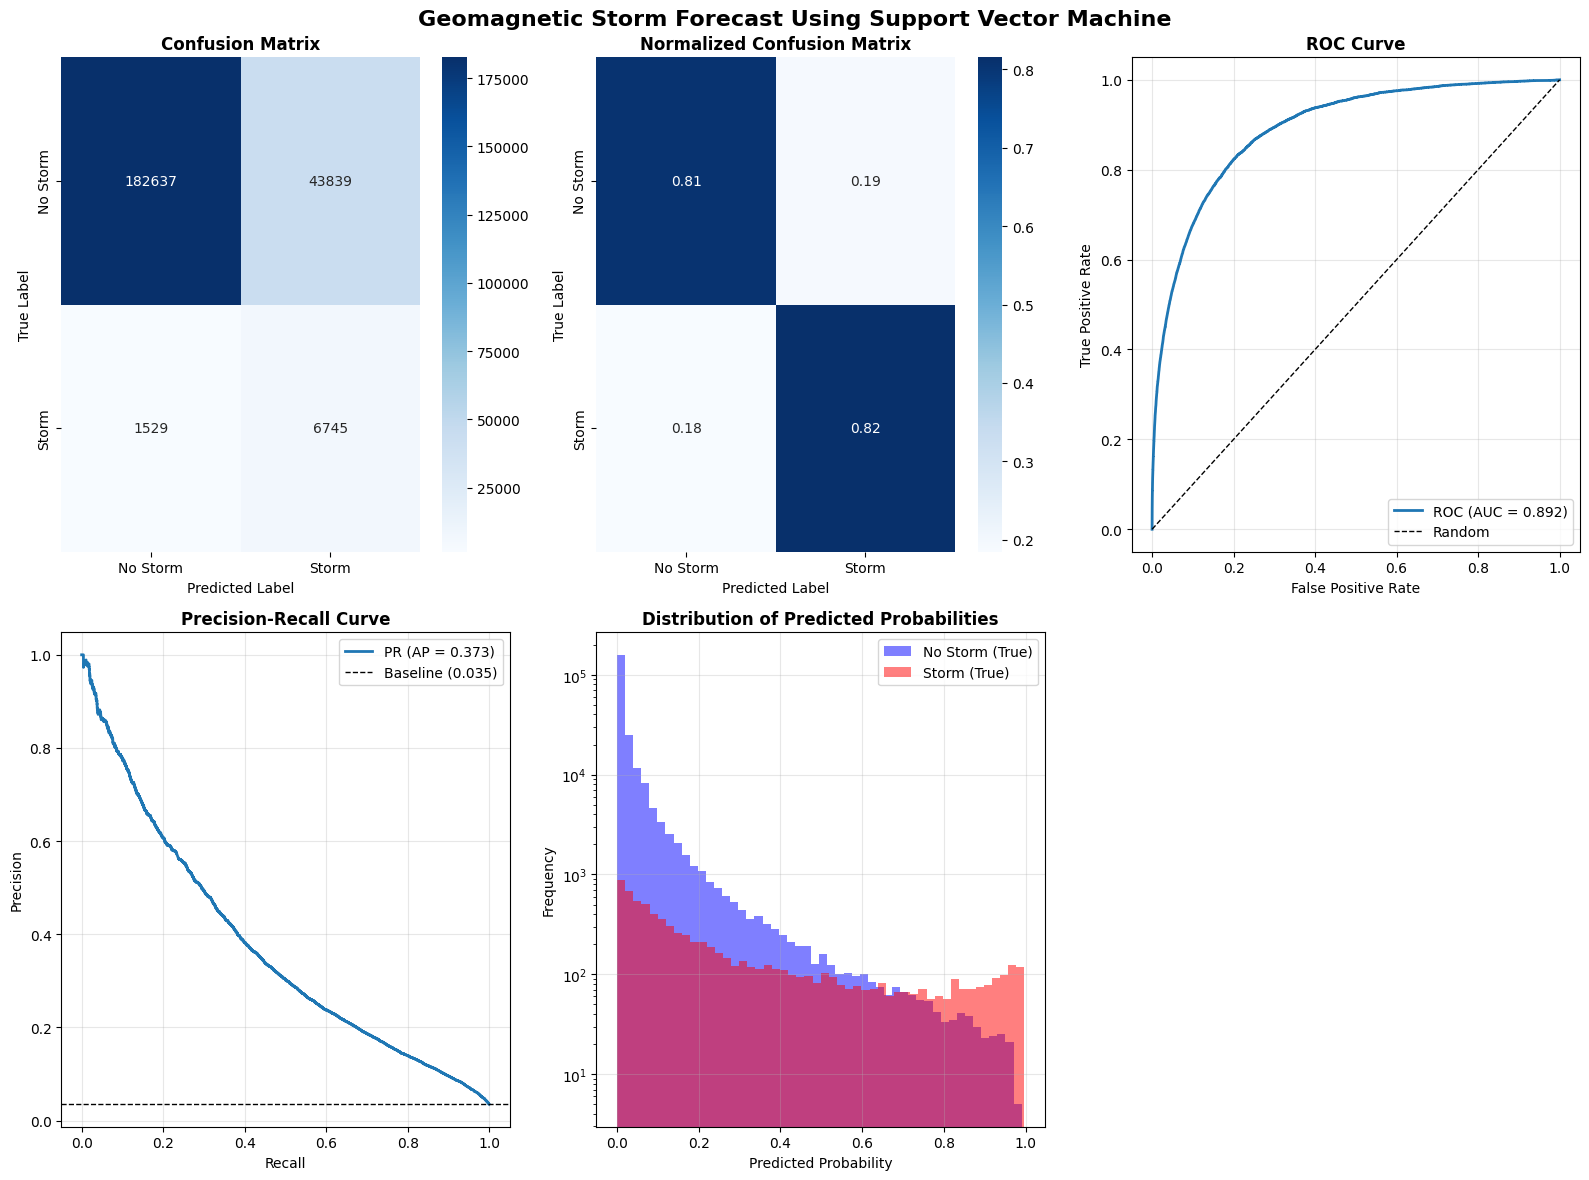

In [23]:
# Visualizations

fig = plt.figure(figsize=(16, 12))
plt.suptitle('Geomagnetic Storm Forecast Using Support Vector Machine', fontsize=16, fontweight='bold')

class_names = ['No Storm', 'Storm']

# 1. Confusion Matrix
ax1 = plt.subplot(2, 3, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1, xticklabels=class_names, yticklabels=class_names)
ax1.set_title('Confusion Matrix', fontsize=12, fontweight='bold')
ax1.set_ylabel('True Label')
ax1.set_xlabel('Predicted Label')

# 2. Normalized Confusion Matrix
cm_norm = pd.DataFrame(cm).apply(lambda x: x/sum(x), axis = 1)
ax2 = plt.subplot(2, 3, 2)
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap='Blues', ax=ax2, xticklabels=class_names, yticklabels=class_names)
ax2.set_title('Normalized Confusion Matrix', fontsize=12, fontweight='bold')
ax2.set_ylabel('True Label')
ax2.set_xlabel('Predicted Label')

# 3. ROC Curve
if len(np.unique(y_test_full)) > 1:
    ax3 = plt.subplot(2, 3, 3)
    fpr, tpr, _ = roc_curve(y_test_full, y_pred_proba)
    ax3.plot(fpr, tpr, linewidth=2, label=f'ROC (AUC = {roc_auc:.3f})')
    ax3.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
    ax3.set_xlabel('False Positive Rate')
    ax3.set_ylabel('True Positive Rate')
    ax3.set_title('ROC Curve', fontsize=12, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

# 4. Precision-Recall Curve
if len(np.unique(y_test_full)) > 1:
    ax4 = plt.subplot(2, 3, 4)
    precision, recall, _ = precision_recall_curve(y_test_full, y_pred_proba)
    ax4.plot(recall, precision, linewidth=2, label=f'PR (AP = {avg_precision:.3f})')
    ax4.axhline(y=y_test_full.mean(), color='k', linestyle='--', linewidth=1, 
                label=f'Baseline ({y_test_full.mean():.3f})')
    ax4.set_xlabel('Recall')
    ax4.set_ylabel('Precision')
    ax4.set_title('Precision-Recall Curve', fontsize=12, fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

# 6. Prediction Probability Distribution
ax6 = plt.subplot(2, 3, 5)
ax6.hist(y_pred_proba[y_test_full == 0], bins=50, alpha=0.5, label='No Storm (True)', color='blue')
ax6.hist(y_pred_proba[y_test_full == 1], bins=50, alpha=0.5, label='Storm (True)', color='red')
ax6.set_xlabel('Predicted Probability')
ax6.set_ylabel('Frequency')
ax6.set_yscale('log')
ax6.set_title('Distribution of Predicted Probabilities', fontsize=12, fontweight='bold')
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/geomag_storm_SVM_results.png', dpi=300, bbox_inches='tight')
print("\nVisualization saved as 'geomag_storm_SVM_results.png'")
plt.show()